## Dependencies and packages

In [14]:
from random import randint
from math import dist, log
import numpy as np
import matplotlib.pyplot as plt

## System topology simulation

### System parameters

In [15]:
K = 4                 # (edge users)
X_LENGTH = 500        # m (horizontal length of area)
Y_LENGTH = 500        # m (vertical length of area)

NOISE_STD = -174      # dBm/Hz (AWGN)
FADE_STD = 8          # dB (path loss)
B = 1000000           # Hz (bandwidth)
P_MAX = 1             # dBm (max power)
C = 1000              # cpu cycles / bit (computational power)
C_COEFF = 10**(-28)   # effective capacitance coefficient
FREQUENCY = 2*10**9   # cpu cycles / sec (cpu frequency)
SEC_RATE_TH = 1       # bit / sec (secure data rate threshold)
T_MAX = 0.1           # sec (time threshold)

### Environment code

In [16]:
class Env:
  # TODO: find a way to calculate the deconding order dec_ord

  # create an instance of Env
  def __init__(self, N_users=K, x_length=X_LENGTH, y_length=Y_LENGTH,
               fade_std=FADE_STD):
    self.N_users = N_users
    self.x_length = x_length
    self.y_length = y_length
    self.fade_std = fade_std
    self.reset()


  # reposition users, update their channel gains (both bs and eve)
  # and get a new state
  def reset(self):
    self.task_sizes = []
    self.bs_coords = (0,0)
    self.eve_coords = (randint(-self.x_length/2*100, self.x_length/2*100)/100,
                      randint(-self.y_length/2*100, self.y_length/2*100)/100)

    # randomly place users in grid
    self.user_coords = []
    for _ in range(self.N_users):
      # multiply and divide by 100 to have two decimal points
      user = (randint(-self.x_length/2*100, self.x_length/2*100)/100,
              randint(-self.y_length/2*100, self.y_length/2*100)/100)
      self.user_coords.append(user)

    # calculate channel gains for each user with respect to BS and eve
    self.user_gains_bs = self._get_channel_gains(self.bs_coords)
    self.user_gains_eve = self._get_channel_gains(self.eve_coords)

    # randomize state of environment
    self.state = self._state_update()


  # return a list of channel gains - one for each user -
  # for the user's channel to the reference point (BS or Eve)
  def _get_channel_gains(self, ref_point):
    user_gains = []
    for user in self.user_coords:
      # path loss model: 128.1 + 37.6*log_10(d) (d is in km)
      user_path_loss = 128.1 + 37.6 *\
       log(dist(ref_point, user) / 1000, 10) +\
       np.random.normal(0, self.fade_std)
      # gain = 1 / path loss
      user_gains.append(1/user_path_loss)
    return user_gains


  # get new tasks
  # return new state
  def _state_update(self):
    # task bit size around 1 to 3 * 10^5 bits
    self.task_sizes = [randint(100000, 300000) for user in range(self.N_users)]
    self.dec_order = [x for x in range(self.N_users)]
    self.state = self.user_gains_bs + self.user_gains_eve +\
      self.task_sizes + self.dec_order
    return self.state


  # get user k's information from state
  # returns tuple (h_k_BS, h_k_eve, S_k)
  def get_state_k(self, k):
    return self.user_gains_bs[k], self.user_gains_eve[k], self.task_sizes[k]


  # get user k's action
  # return tuple (p_k_1, p_k_2, s_k)
  # action is structured as
  #         [p_1_total, p_2_total, ..., p_K_total,
  #          p_1_1/p_1_total, p_2_1/p_2_total, ..., p_K_1/p_K_total,
  #          s_1, s_2, ..., s_K]
  def get_action_k(self, k, action):
    return action[k], action[self.N_users + k], action[2 * self.N_users + k]


  # update state based on action and get new state and reward
  def step(self, action):
    # reward calculation is dependent on the current state
    reward = self._reward(action)
    self.state = self._state_update()
    return self.state, reward


  # calculate reward
  # the model tries to maximize the reward and we try to minimize the energy
  # consumption so -Energy_total is used
  # QoS ranges from 1 to 2, the lower the better
  # lower QoS value lowers the reward we try to minimize
  # QoS value shouldn't be zero because the energy's effect is negated
  def _reward(self, action):
    return -self._energy_sum(action) * self._qos(action)


  # return the total energy consumed in the last timeslot
  def _energy_sum(self, action):
    energy_total = 0
    for user_k in range(self.N_users):
      energy_total += self._energy_offload_k(user_k, action) +\
        self._energy_execution_k(user_k, action)

    return energy_total


  # quality of service indicator, ranges from 1 (great) to 2 (bad)
  # offset +1 because a zero value would negate the effect of energy
  # in reward calculation
  def _qos(self, action):
    res = 0
    for user in range(self.N_users):
      sec_data_rate_k_1, sec_data_rate_k_2 = \
        self._secure_data_rate_k(user, action)
      offload_time = self._offload_time_k(user, action)
      execution_time = self._execution_time_k(user, action)

      if (sec_data_rate_k_1 > SEC_RATE_TH and
        sec_data_rate_k_2 > SEC_RATE_TH and
        max(offload_time, execution_time) > T_MAX):
        res += 1

    return res / self.N_users + 1


  # return the total energy consumed for execution of local task at user
  def _energy_execution_k(self, k, action):
    _, _, user_split = self.get_action_k(k, action)
    _, _, task_total = self.get_state_k(k)

    return C_COEFF * FREQUENCY ** 2 * (1 - user_split) * task_total


  # return offload time
  def _offload_time_k(self, k, action):
    user_p1, user_p2, user_split = self.get_action_k(k, action)
    channel_bs, channel_eve, task_total = self.get_state_k(k)

    # calculate the required time for offloading
    sec_data_rate_k_1, sec_data_rate_k_2 = self._secure_data_rate_k(k, action)
    sec_data_rate_k = sec_data_rate_k_1 + sec_data_rate_k_2
    if sec_data_rate_k > 0:
      offload_time = user_split * task_total / (C * sec_data_rate_k)
    else:
      offload_time = T_MAX + 1
    return offload_time


  # return execution time
  def _execution_time_k(self, k, action):
    _, _, offload_task = self.get_action_k(k, action)
    _, _, task_total = self.get_state_k(k)
    return (1 - offload_task) * task_total / FREQUENCY


  # return the energy a user requires to offload their task
  def _energy_offload_k(self, k, action):
    user_p1, user_p2, _ = self.get_action_k(k, action)
    offload_time = self._offload_time_k(k, action)
    return (user_p1 + user_p2) * offload_time


  # return the secure data rates for user k
  def _secure_data_rate_k(self, k, action):
    user_p1, user_p2, _ = self.get_action_k(k, action)
    channel_bs, channel_eve, _ = self.get_state_k(k)

    # calculate first message's achievable rate of decoding at BS
    bs_interference = self._interference_bs_k(k, action)
    log_arg = 1 + channel_bs * user_p1 / \
        (bs_interference + channel_bs * user_p2 + NOISE_STD * B)
    rate_bs_1 = B * log(log_arg, 2)


    # calculate first message's achievable rate of decoding at eavesdropper
    eve_interference = self._interference_eve_k(k, action)
    log_arg = 1 + channel_eve * user_p1 / \
        (eve_interference + channel_eve * user_p2 + NOISE_STD * B)
    rate_eve_1 = B * log(log_arg, 2)

    secure_data_rate_1 = max(0, rate_bs_1 - rate_eve_1)   # first message

    # calculate second message's achievable rates
    # base station
    log_arg = 1 + channel_bs * user_p2 / \
        (bs_interference + NOISE_STD * B)
    rate_bs_2 = B * log(log_arg, 2)

    # eavesdropper
    log_arg = 1 + channel_eve * user_p2 / \
        (eve_interference + channel_eve * user_p1 + NOISE_STD * B)
    rate_eve_2 = B * log(log_arg, 2)

    secure_data_rate_2 = max(0, rate_bs_2 - rate_eve_2)   # second message

    return secure_data_rate_1, secure_data_rate_2


  # calculate the interference to the BS for a user's signal
  # only interference from messages decoded after the user's second message
  # is calculated in the BS
  def _interference_bs_k(self, k, action):
    decoding_order = self.dec_order
    interference = 0
    for user in decoding_order[k+1:]:
      user_p1, user_p2, _ = self.get_action_k(user, action)
      channel_bs, _, _ = self.get_state_k(user)
      interference += (user_p1 + user_p2) * channel_bs
    return interference


  # calculate the interference to the eavesdropper for a user's signal
  def _interference_eve_k(self, k, action):
    interference = 0
    for user in range(self.N_users):
      if user == k:
        continue
      user_p1, user_p2, _ = self.get_action_k(user, action)
      _, channel_eve, _ = self.get_state_k(user)
      interference += (user_p1 + user_p2) * channel_eve
    return interference


  # visualize the environment
  def render(self):
    user_plot_x = []
    user_plot_y = []
    for user_x, user_y in self.user_coords:
      user_plot_x.append(user_x)
      user_plot_y.append(user_y)

    plt.scatter(self.bs_coords[0], self.bs_coords[1], color='green', marker='x',
                label='Base Station')
    plt.scatter(self.eve_coords[0], self.eve_coords[1], color='red', marker='x',
                label='Eavesdropper')
    plt.scatter(user_plot_x, user_plot_y, color='blue', marker='o',
                label='Users')

    plt.xlim(-self.x_length/2, self.x_length/2)
    plt.ylim(-self.y_length/2, self.y_length/2)
    plt.legend()

### Create a cell instance for testing


In [17]:
env = Env()

In [18]:
env.step([1, 1, 1, 1,
          0.5, 0.5, 0.5, 0.5,
          0.5, 0.5, 0.5, 0.5])

([0.01090872141955426,
  0.010922992085363181,
  0.009674247938814181,
  0.008806043415225734,
  0.010418702649833253,
  0.009461048294183566,
  0.008852374645117267,
  0.008900096354706661,
  229032,
  125477,
  262536,
  136040,
  0,
  1,
  2,
  3],
 -144613282.53110552)

In [19]:
for i in range(K):
  print("Edge user at ({},{}) with BS channel gain {}".format(
      env.user_coords[i][0], env.user_coords[i][1], env.user_gains_bs[i]
  ))

Edge user at (19.55,-166.02) with BS channel gain 0.01090872141955426
Edge user at (153.18,119.99) with BS channel gain 0.010922992085363181
Edge user at (226.35,224.2) with BS channel gain 0.009674247938814181
Edge user at (-221.21,167.42) with BS channel gain 0.008806043415225734


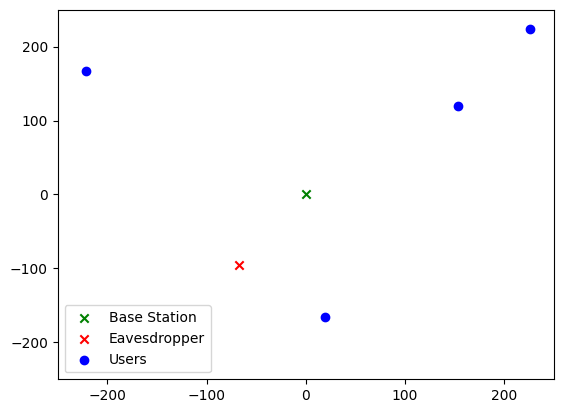

In [20]:
env.render()

## Multi-Agent DDPG (MADDPG)

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, InputLayer, Concatenate
from tensorflow.keras import Model

# channel_gain_BS, channel_gain_EVE, task_size, decoding_order
state_size = 4
# total_power, first_message_power_ratio, task_size_ratio
action_size = 3

In [ ]:
# the actor network receives the state as an input
# has two hidden layers of size 400 and 300 respectively with ReLU activation
# has sigmoid output of size equal to the number of actions
class ActorNetwork(Model):
  def __init__(self):
    self.N_users = K

    super().__init__()
    self.input_layer = InputLayer(state_size)
    self.hidden_1 = Dense(400, activation='relu')
    self.hidden_2 = Dense(300, activation='relu')
    self.output = Dense(action_size, activation='sigmoid')

  def call(self, state):
    x = self.input_layer(state)
    x = self.hidden_1(x)
    x = self.hidden_2(x)
    return self.output(x)


# the critic network receives the global state as an input and
# the action taken as an input in the second layer
# has two hidden layers of size 400 and 300 respectively with ReLU activation
# has single output returning loss function
class CriticNetwork(Model):
  def __init__(self):
    self.N_users = K

    super().__init__()
    self.input_layer = InputLayer(state_size * self.N_users)
    self.hidden_1 = Dense(400, activation='relu')
    self.action_layer = InputLayer(action_size * self.N_users)
    self.concat = Concatenate()
    self.hidden_2 = Dense(300, activation='relu')
    self.output = Dense(1)

  def call(self, state, actions):
    x = self.input_layer(state)
    x = self.hidden_1(x)
    acts = self.action_layer(actions)
    x = self.concat([x, acts])
    x = self.hidden_2(x)
    return self.output(x)

In [26]:
class MADDPG(object):
  def __init__(self, env, n_agents, state_dim, action_dim, mem_capacity=10000,
               roll_out_n_steps=10):
    self.env = env
    self.n_agents = n_agents
    self.state_dim = state_dim
    self.action_dim = action_dim
    self.mem_capacity = mem_capacity
    self.roll_out_n_steps = roll_out_n_steps

    # self.actors = [ActorNetwork(self.state_dim, self.)]

SyntaxError: ignored

### Training

In [22]:
actor_num_states = 3    # S_k, hbs_k, he_k
critic_num_states = 3 * K
actor_num_actions = 3   # pk_1, pk_2, s_k
critic_num_actions = 3 * K

In [23]:
timeslots = 200
episodes = 2000
update_time = 100

In [24]:
def train():
  pass # randomly initialize actor and critic networks at BS
  for user_i in range(K):
    pass # randomly initialize actor network at BS
  for episode in range(episodes):
    env = Env()
    for timeslot in range(timeslots):
      for user_i in range(K):
        pass  # action = local_actor.predict(local_state)
        pass # reward, new_state = local_actor.execute(action)
        pass # send experience tuple to BS
      pass # critic.combine(exp_tuples)
      pass # critic.buffer.add(random(exp_tuple))
      pass # critic.update(random(exp_tuples))
      pass # actor.update()
      if ((episode*timeslots + timeslot) % update_time == 0):
        pass # update local actors